# **Preprocess the dataset and stores tensors to Google Driver**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = os.path.join('/content/drive/MyDrive/')

Mounted at /content/drive


##**Read data files** ##

Read dataframes from csv files

In [ ]:
import pandas as pd
import os

path = '/content/drive/MyDrive'
train_file = os.path.join(path, 'combined_train.csv')
val_file = os.path.join(path, 'combined_val.csv')
test_file = os.path.join(path, 'combined_test.csv')

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

Read train, validation, test data

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00


Load pretrained ViLT model

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

Preprocess the images and comments to encodings and stores them to the storage

##**Finetune the ViLT model** ##

create dataloaders

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import Resize
import torchvision
import numpy as np

class ViltDataset(Dataset):
  def __init__(self, dataframes):
    self.base_path = '/content/drive/MyDrive'
    self.img_paths = dataframes['filename']
    self.comments = dataframes['clean_comments']
    self.resize = Resize((384, 512))
    self.labels = dataframes['scenic']

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = self.resize(read_image(os.path.join(self.base_path, img_path), mode=torchvision.io.ImageReadMode.RGB))
    comment = self.comments[idx]
    encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)
    label = torch.nn.functional.one_hot(torch.tensor(self.labels[idx]), num_classes=2)

    return [encoding, label]

In [ ]:
# create dataloaders
training_data = ViltDataset(train_df[:])
test_data = ViltDataset(test_df[:])
val_data = ViltDataset(val_df[:])

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True)

Define a classifier model

In [ ]:
class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [ ]:
class ScenicClassifier2(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Linear(enc_features, 2, bias=False)
    torch.nn.init.xavier_uniform(self.classifier.weight)

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [ ]:
device='cuda:0'
# device='cpu'
classifier = ScenicClassifier(768)
# classifier = ScenicClassifier2(768)
classifier.to(device)

criterion = torch.nn.MSELoss()
criterion.to(device)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.0001, momentum=0.8)

## Train the model

In [ ]:
classifier.train()
loss_log = []
epoch_loss = 0.0
for epoch in range(2):
  running_loss = 0.0
  epoch_loss_log = []
  for i, data in enumerate(train_dataloader, 0):
    encodings, labels = data
    encodings.to(device)
    labels.to(device)
    for key in encodings.keys():
      encodings[key] = torch.squeeze(encodings[key], 1)
    optimizer.zero_grad()
    outputs = classifier(encodings)
    labels = torch.tensor(labels, dtype=torch.float).cuda()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 10 == 9:
      print(f'[{epoch+1}, {i+1:5d}] loss : {running_loss / 10:.3f}')
      epoch_loss = running_loss / 10.0
      epoch_loss_log.append(epoch_loss)
      running_loss=0.0

  loss_log.append(epoch_loss_log)

print('Finished training')

<ipython-input-35-b81db43217f6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float).cuda()


[1,    10] loss : 0.665
[1,    20] loss : 0.510
[1,    30] loss : 0.391
[1,    40] loss : 0.315
[1,    50] loss : 0.263
[1,    60] loss : 0.227
[1,    70] loss : 0.198
[1,    80] loss : 0.189
[1,    90] loss : 0.165
[1,   100] loss : 0.169
[1,   110] loss : 0.164
[1,   120] loss : 0.164
[1,   130] loss : 0.150
[1,   140] loss : 0.136
[1,   150] loss : 0.140
[1,   160] loss : 0.141
[1,   170] loss : 0.140
[1,   180] loss : 0.133
[1,   190] loss : 0.120
[1,   200] loss : 0.140
[1,   210] loss : 0.124
[1,   220] loss : 0.122
[1,   230] loss : 0.124
[1,   240] loss : 0.113
[1,   250] loss : 0.128
[2,    10] loss : 0.100
[2,    20] loss : 0.107
[2,    30] loss : 0.124
[2,    40] loss : 0.097
[2,    50] loss : 0.119
[2,    60] loss : 0.106
[2,    70] loss : 0.107
[2,    80] loss : 0.107
[2,    90] loss : 0.106
[2,   100] loss : 0.108
[2,   110] loss : 0.105
[2,   120] loss : 0.099
[2,   130] loss : 0.111
[2,   140] loss : 0.116
[2,   150] loss : 0.103
[2,   160] loss : 0.096
[2,   170] loss 

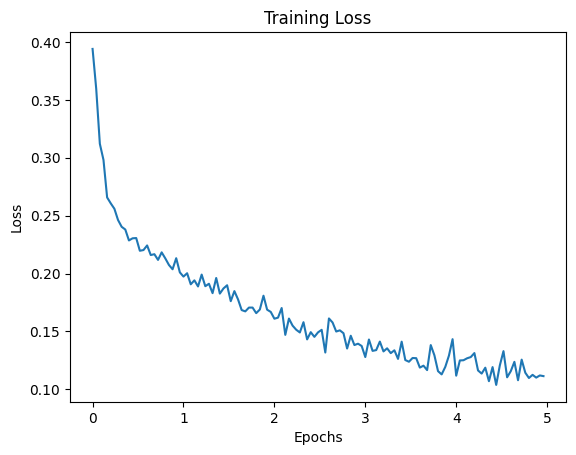

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

x_ = np.arange(0, len(loss_log), 1.0/len(loss_log[0]))
y_ = np.reshape(np.array(loss_log), -1)
plt.plot(x_, y_)

Store the finetuned model to the Google drive

In [ ]:
device = 'cuda:0'
classifier = ScenicClassifier(768)
classifier.to(device)

criterion = torch.nn.MSELoss()
criterion.to(device)

momentum_values = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  # List of momentum values to try
best_momentum = 0.0
lowest_loss = float('inf')

for momentum in momentum_values:
    print(f"Training with momentum: {momentum}")

    # Reset the model and optimizer for each momentum value
    classifier = ScenicClassifier(768)
    classifier.to(device)
    optimizer = torch.optim.SGD(classifier.parameters(), lr=0.0001, momentum=momentum)

    classifier.train()
    loss_log = []

    for epoch in range(5):
        running_loss = 0.0
        epoch_loss_log = []

        for i, data in enumerate(train_dataloader, 0):
            encodings, labels = data
            encodings.to(device)
            labels.to(device)

            for key in encodings.keys():
                encodings[key] = torch.squeeze(encodings[key], 1)

            optimizer.zero_grad()
            outputs = classifier(encodings)
            labels = torch.tensor(labels, dtype=torch.float).cuda()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 10 == 9:
                print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss / 10:.3f}')
                epoch_loss = running_loss / 10.0
                epoch_loss_log.append(epoch_loss)
                running_loss = 0.0

        loss_log.append(epoch_loss_log)

    avg_loss = sum([sum(log) for log in loss_log]) / len(loss_log)
    if avg_loss < lowest_loss:
        lowest_loss = avg_loss
        best_momentum = momentum

print(f"Best Momentum Value: {best_momentum}")
print("Finished training")


Training with momentum: 0.5


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-16-ac7c8d4fa2c7>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float).cu

[1,    10] loss: 0.516
[1,    20] loss: 0.472
[1,    30] loss: 0.436
[1,    40] loss: 0.398
[1,    50] loss: 0.369
[1,    60] loss: 0.345
[1,    70] loss: 0.313
[1,    80] loss: 0.306
[1,    90] loss: 0.287
[1,   100] loss: 0.276
[1,   110] loss: 0.268
[1,   120] loss: 0.263
[1,   130] loss: 0.242
[1,   140] loss: 0.229
[1,   150] loss: 0.245
[1,   160] loss: 0.225
[1,   170] loss: 0.226
[1,   180] loss: 0.224
[1,   190] loss: 0.210
[1,   200] loss: 0.211
[1,   210] loss: 0.216
[1,   220] loss: 0.210
[1,   230] loss: 0.220
[1,   240] loss: 0.207
[1,   250] loss: 0.210
[2,    10] loss: 0.197
[2,    20] loss: 0.194
[2,    30] loss: 0.193
[2,    40] loss: 0.191
[2,    50] loss: 0.194
[2,    60] loss: 0.196
[2,    70] loss: 0.197
[2,    80] loss: 0.175
[2,    90] loss: 0.189
[2,   100] loss: 0.182
[2,   110] loss: 0.178
[2,   120] loss: 0.188
[2,   130] loss: 0.180
[2,   140] loss: 0.185
[2,   150] loss: 0.176
[2,   160] loss: 0.186
[2,   170] loss: 0.181
[2,   180] loss: 0.171
[2,   190] 

RuntimeError: ignored

In [ ]:
model_path = '/content/drive/MyDrive/scenic_model_bilal_new_hyperparams.pt'
torch.save(classifier.state_dict(), model_path)

NameError: ignored

## Test the result

In [ ]:
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = 'cuda:0'

def f1_score_eval(dataloader, dataname):
  correct = 0
  total = 0
  predicts = torch.zeros(0)
  groundtruth = torch.zeros(0)
  with torch.no_grad():
    for testdata in dataloader:
      encodings, labels = testdata
      encodings = encodings.to(device)
      for key in encodings.keys():
        encodings[key] = torch.squeeze(encodings[key], 1)
      output = classifier(encodings)
      _, predicted = torch.max(output.data, 1)
      # print(predicts)
      # print(torch.argmax(labels.to('cpu'), 1))
      predicts = torch.cat((predicts.to(device), predicted.to(device)), 0)
      total+= labels.size(0)
      groundtruth = torch.cat((groundtruth.to(device), labels.to(device)), 0)
      correct+=(predicted.to(device)==torch.argmax(labels.to(device), 1)).sum().item()

  print(f'Accuracy of the network on {dataname} images : {100*correct//total}%')

  # draw confusion matrix
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
  predicts = torch.tensor(predicts[:], dtype=torch.int)
  conf_mat = confusion_matrix(groundtruth.cpu().numpy(), predicts.cpu().numpy())
  f1_score_ = f1_score(groundtruth.cpu().numpy(), predicts.cpu().numpy())
  print(f'F1-score of the network on {dataname} images : {f1_score_}')

  print(classification_report(groundtruth.cpu(), predicts.cpu()))
  plt.figure(figsize=(10,7))
  sns.heatmap(conf_mat, annot=True, cmap='Blues')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title(dataname)
  plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on validation images : 87%
F1-score of the network on validation images : 0.8705402650356778
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       498
           1       0.89      0.85      0.87       502

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



<ipython-input-14-eac418f02df1>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
<ipython-input-14-eac418f02df1>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = torch.tensor(predicts[:], dtype=torch.int)


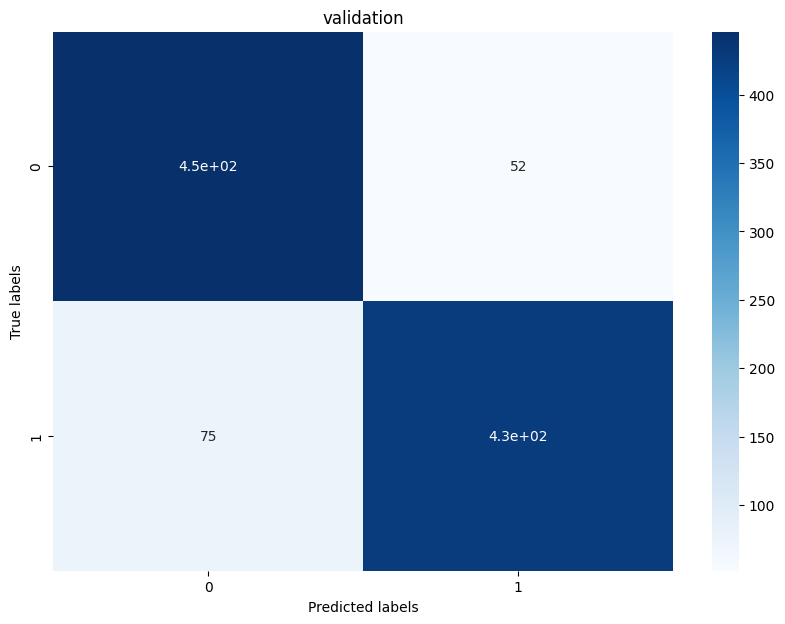

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on test images : 86%
F1-score of the network on test images : 0.8598130841121494
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       505
           1       0.88      0.84      0.86       495

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000



<ipython-input-14-eac418f02df1>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
<ipython-input-14-eac418f02df1>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = torch.tensor(predicts[:], dtype=torch.int)


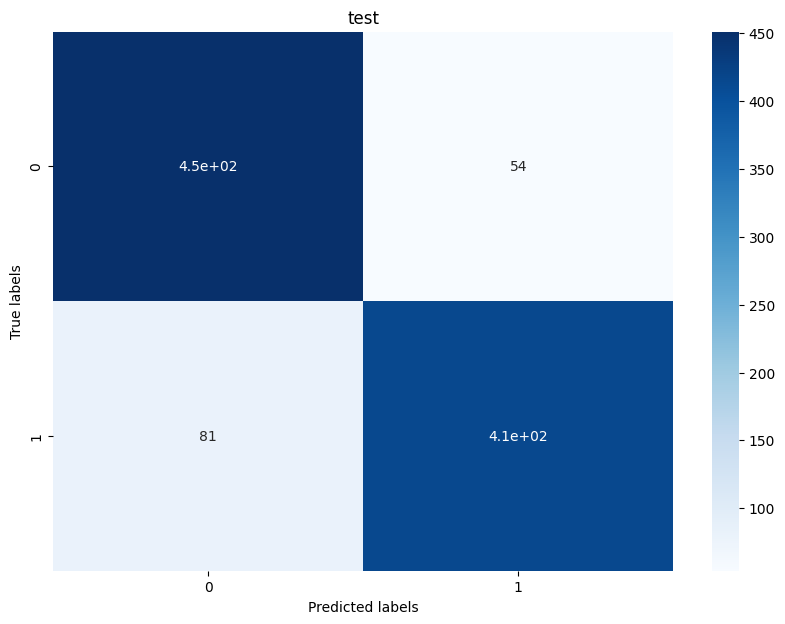

In [ ]:
f1_score_eval(val_dataloader, 'validation')
f1_score_eval(test_dataloader, 'test')

##**QUALITATIVE ANALYSIS**##

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [ ]:
import torch
model_path = '/content/drive/MyDrive/scenic_model_bilal_new.pt'
classifier = ScenicClassifier(768)
classifier.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
classifier.eval()

In [ ]:
test_df['average']

0      7.333
1      2.286
2      3.857
3      8.833
4      1.750
       ...  
995    6.833
996    6.600
997    3.500
998    7.000
999    3.333
Name: average, Length: 1000, dtype: float64

In [ ]:

# # 1. Selecting Specific Cases
# high_scenic = test_df[test_df['average'] > 9.5].sample(1)
# mid_scenic = test_df[(test_df['average'] > 5.5) & (test_df['average'] < 6.5)].sample(1)
# low_scenic = test_df[test_df['average'] < 3].sample(1)
# very_low_scenic = test_df[test_df['average'] < 2].sample(1)

# selected_cases = [high_scenic, mid_scenic, low_scenic, very_low_scenic]

high_scenic = test_df[test_df['average'] > 9.5].sample(1)
mid_scenic = test_df[(test_df['average'] > 5.5) & (test_df['average'] < 6.5)].sample(1)
low_scenic = test_df[test_df['average'] < 3].sample(1)
very_low_scenic = test_df[test_df['average'] < 2].sample(1)

selected_cases = [high_scenic, mid_scenic, low_scenic, very_low_scenic]


In [ ]:
print(test_df.columns)


Index(['Unnamed: 0', 'ID', 'Lat', 'Lon', 'Average', 'Variance', 'Votes',
       'Geograph URI', 'gridimage_id', 'imageclass', 'comment', 'tags',
       'filename', 'realname', 'title', 'imagetaken', 'user_id',
       'moderation_status', 'average', 'tags_word_count',
       'comments_word_count', 'clean_comments', 'scenic', 'input_ids',
       'attention_mask'],
      dtype='object')


In [ ]:
# test_data = ViltDataset(case)
# print(test_data[0])  # This should print the first (and only) item in the dataset


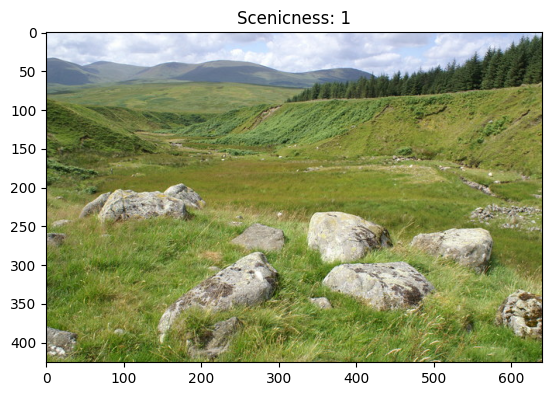

Comment: polsue burn rise high slope cairnsmore carsphairn lower section valley widens burn swing west join water deogh
Predicted Scenicness: 1
Actual Scenicness: 1
The model accurately predicted the scenicness.


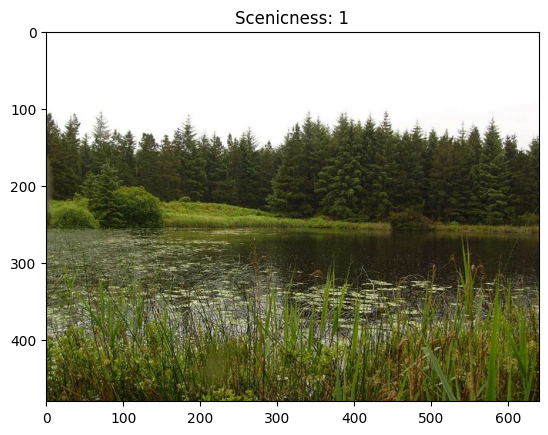

Comment: pouring rain
Predicted Scenicness: 1
Actual Scenicness: 1
The model accurately predicted the scenicness.


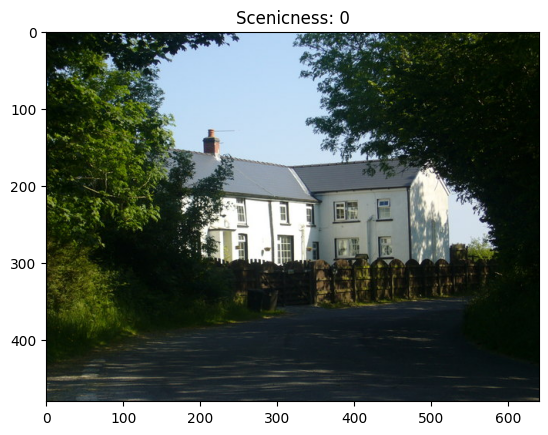

Comment: name house
Predicted Scenicness: 0
Actual Scenicness: 0
The model accurately predicted the scenicness.


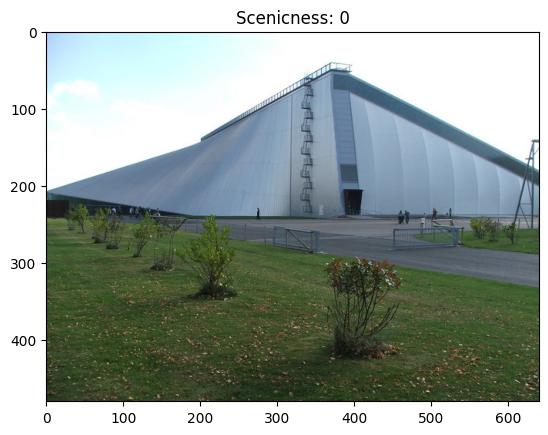

Comment: striking modern building aircraft suspended wire odd angles giving impression enthusiast attic bedroom purist hate display canot easily get straight view single aircraft ingenious way fitting though
Predicted Scenicness: 0
Actual Scenicness: 0
The model accurately predicted the scenicness.


In [ ]:
# ... [rest of the code]

# 2. Displaying the Images and Descriptions
for case in selected_cases:
    # Reset the index to ensure that the sampled data is a DataFrame
    case_df = case.reset_index(drop=True)

    img_path = os.path.join('/content/drive/MyDrive', case_df['filename'].iloc[0])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Scenicness: {case_df['scenic'].iloc[0]}")
    plt.show()
    print(f"Comment: {case_df['clean_comments'].iloc[0]}")

    # 3. Model Predictions
    test_data = ViltDataset(case_df)
    dataloader = DataLoader(test_data, batch_size=1)
    for data in dataloader:
        encodings, labels = data
        for key in encodings.keys():
            encodings[key] = torch.squeeze(encodings[key], 1)
        outputs = classifier(encodings)
        predicted = torch.argmax(outputs, 1)
        print(f"Predicted Scenicness: {predicted.item()}")

    # 4. Discussion
    # This is more subjective and would require human interpretation.
    # For instance:
    print(f"Actual Scenicness: {case_df['scenic'].iloc[0]}")
    if predicted.item() == case_df['scenic'].iloc[0]:
        print("The model accurately predicted the scenicness.")
    else:
        print("The model's prediction deviated from the actual scenicness.")


In [ ]:
# can be used to reduce the GPU allocation memory
torch.cuda.empty_cache()
!nvidia-smi -caa
!nvidia-smi

Cleared Accounted PIDs for GPU 00000000:00:04.0.
All done.
Thu Sep  7 15:38:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   2265MiB / 15360MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                             